In [3]:
##### If running this notebook on visual studio code, 
# uv add --dev ipykernel
#uv add --dev ipykernel
#code .
#+ install dependencies as needed

## Root Mean Square Error cost with Bad Initialization
<p>What happens when we use the root mean square error cost or total loss function, while having a bad initialization value for the parameters?</p>
<ul>
    <li><a href="#data">Data</a></li>
    <li><a href="#model">Create the Model and Loss function</a></li>
    <li><a href="#training">Training: Batch Gradient Descent</a></li>
</ul>

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [39]:
# Helper class: Plotting

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - (1 / (1 + np.exp(-1*w2 * self.x - b2)))) ** 2)
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(5.5, 3))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Iteration - Data space: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Iteration - Loss Surface Contour' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

In [8]:
# Set random seed / Useful for repeatability
torch.manual_seed(0)

## <a name="data" id="data">Data: Get some data</a>

In [9]:
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [10]:
# Calling the class Data to create a data object
data_set = Data()

## <a name="model" id="model">Model: Create the model and Loss function</a>

In [11]:
# Logistic_regression class
class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        y_hat = torch.sigmoid(self.linear(x))
        return y_hat

In [12]:
# Creation of the model
model = logistic_regression(1)

In [13]:
# Set the weight and bias
# In this exercise, we want to replace the random initialized variable values 
# with some predetermined values that will not converge:
model.state_dict() ['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict() ['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict({'linear.weight': tensor([[-5.]]), 'linear.bias': tensor([-10.])})


## <a name="training" id="training">Training</a>

### Preparing visualization for training

<Figure size 640x480 with 0 Axes>

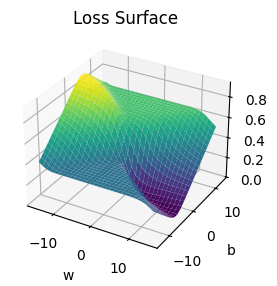

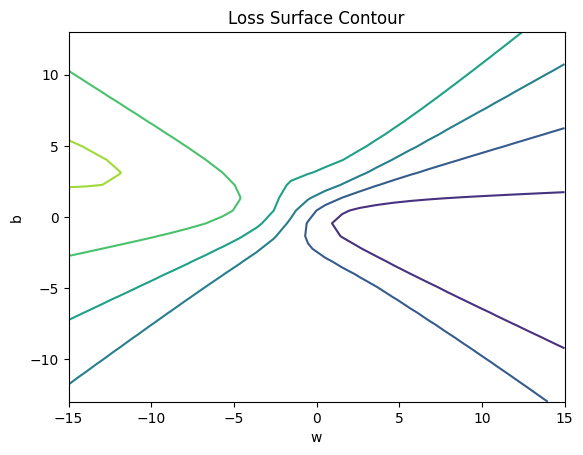

In [40]:
# Create a `plot_error_surfaces` object. 
# We will use this object to visualize the data space
# and the parameter space during training:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

In [15]:
# Define the dataloader, the cost (criterion) function, and the optimizer: 
train_loader = DataLoader(dataset=data_set, batch_size=3)

criterion_rms = nn.MSELoss()

learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
print('Some info:')
print(f'train_loader is a: {type(train_loader)}')  
print(f'Length: {len(train_loader)}')  

Some info:
train_loader is a: <class 'torch.utils.data.dataloader.DataLoader'>
Length: 7


### Training the model using Batch Gradient Descent

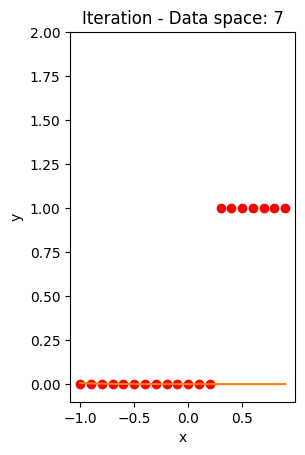

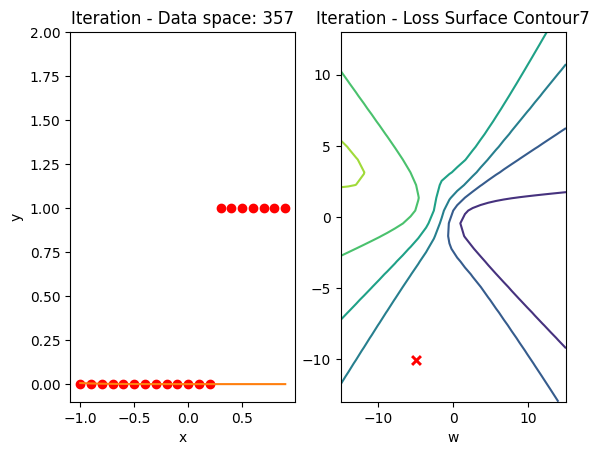

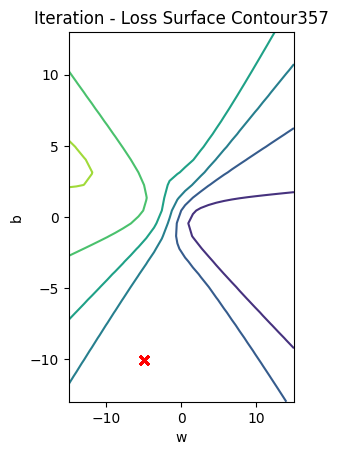

In [41]:
def train_model(epochs):

    for epoch in range(epochs):
        # iterate through data subsets
        for x, y in train_loader: 
            
            y_hat = model(x)  # Compute output
            loss = criterion_rms(y_hat, y)  # Measure loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            get_surface.set_para_loss(model, loss.tolist())  # Visualization
        # Visualize every given number of epochs
        visualization_step = 50    
        if epoch % visualization_step == 0:
            get_surface.plot_ps()

train_model(100)

In [52]:
# Make the Prediction

y_hat = model(data_set.x)
label = y_hat > 0.5
accuracy = torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)).item() * 100
print(f'Accuracy: {accuracy:.2f}%')
# Accuracy is ~60%

Accuracy: 65.00%
